<a href="https://colab.research.google.com/github/ManelGH1167/MasterIA/blob/main/Portafolio_Art%C3%ADculo_Cient%C3%ADfico_Conv_1_Manel_Gonzalez_Huete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arquitectura CAE (Figura 3)

**Autor:** Manel González Huete<br>
**Grupo:** C

La figura 3 del artículo describe la arquitectura de un Convolutional AutoEncoder (CAE) utilizada como tarea previa en el marco del aprendizaje no supervisado propuesto. Se muestra un CAE con un encoder, un módulo de atención convolucional (el bottleneck) y un decoder, utilizando capas convolucionales y stride > 1, en lugar de pooling/upsampling.

Otras fuentes de imágenes médicas:
* The Cancer Imaging Archive (TCIA) - https://www.cancerimagingarchive.net/

* Histopathologic Cancer Detection - https://www.kaggle.com/c/histopathologic-cancer-detection/data

* Kaggle: Histology & Pathology datasets - https://www.kaggle.com/datasets?search=histology

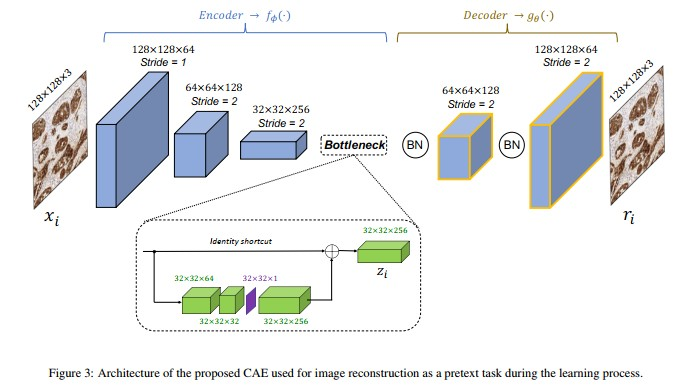

**NOTA:** Este código implementa solo el CAE de la figura 3, que es la primera etapa del marco propuesto ya que en la figura 4 (DCEAC) se añade la parte del clustering con GAP y Student’s t-distribution.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Configuración global
INPUT_SHAPE = (128, 128, 3)  # Tamaño de entrada: 128x128x3 (RGB, redimensionado desde 512x512 según el artículo)
NUM_BATCH = 94               # Número de batchs según sección 3.1
# EPOCHS = 200               # Número de épocas para pre-entrenamiento
EPOCHS = 10                  # PARA PRUEBAS........................................
LEARNING_RATE = 0.5          # Tasa de aprendizaje para Adadelta

### Crear estructura CAE

In [ ]:
# --- Bottleneck Residual Block ---
# Bottleneck: 32x32x256 (tras atención).
# El texto (sección 3.1) dice: "The proposed module combines 1×1 convolutions (green boxes) with a sigmoid
# function (purple layer) intended to recalibrate the inputs."
# "An additional 1×1 convolutional layer was included to modify the filter channel without affecting the
# dimension of the feature maps."
def bottleneck_block(x_input):
    """
    Implementa el módulo de atención convolucional en el bottleneck. La entrada al bottleneck
    proviene de una capa convolucional con 256 filtros (tercera capa del encoder), y el shortcut
    implica que la salida del módulo debe mantener esa misma dimensionalidad (32x32x256) para
    la suma residual: 32x32x256 → 32x32x64 → 32x32x32 → 32x32x256
        conv1: Reduce de 256 a 64 canales (32x32x64).
        conv2: Reduce de 64 a 32 canales (32x32x32).
        sigmoid: Aplica recalibración en 32x32x32, interpretando esto como la "capa púrpura" (sigmoide)
        conv3: Restaura a 256 canales (32x32x256) para el shortcut.
        output: Suma residual con la entrada original (32x32x256).

    Params:
        input_tensor (tf.Tensor): Tensor de entrada desde el encoder (32x32x256).

    Returns:
        tf.Tensor: Tensor procesado con atención y conexión residual.
    """
    shortcut = x_input

    # Primera convolución 1x1: reduce a 64 canales - 32x32x64
    conv1= layers.Conv2D(filters=64, kernel_size=1, padding='same', activation='relu', name='attn_conv1')(x_input)
    # Segunda convolución 1x1: reduce a 32 canales (squeeze) - 32x32x32
    conv2 =layers.Conv2D(filters=32, kernel_size=1,padding='same', activation='relu', name='attn_conv2')(conv1)
    # Sigmoide para recalibración - # 32x32x32
    sigmoid = layers.Activation(activation='sigmoid', name='attn_sigmoid')(conv2)
    # Restaurar a 256 canales con convolución 1x1 (excitation)
    conv3 = layers.Conv2D(filters=256, kernel_size=1, padding='same', activation=None, name='attn_conv3')(sigmoid)

    # Shortcut: suma residual con la entrada original - 32x32x256
    output = layers.Add(name='attn_residual')([shortcut, conv3])

    return output

In [ ]:
# --- Encoder ---
# Tres capas convolucionales con filtros crecientes (64, 128, 256) y kernel 3x3,
# como se describe (en la figura 3). Stride = 2 en cada capa para reducir las dimensiones espaciales sin usar
# pooling, siguiendo el texto: "we worked with a stride > 1 both in the encoder and decoder structures".
# Activación ReLU para no linealidad.
# Encoder: 128x128x3 → 128x128x64 → 64x64x128 → 32x32x256.
def build_encoder(input_shape=INPUT_SHAPE):
    """
    Construye el encoder del CAE con tres capas convolucionales.

    Params:
        input_shape (tuple): Forma de la entrada (alto, ancho, canales). Por defecto: (128, 128, 3).

    Return:
        tf.keras.Model: Modelo del encoder como salida (hacia el bottleneck).
    """
    inputs = layers.Input(shape=input_shape, name='encoder_input')

    # Primera capa: stride=1 para preservar resolución inicial: 128x128x64
    x = layers.Conv2D(filters=64,  kernel_size=3, padding='same', strides=1, activation='relu', name='encd_conv1')(inputs)
    # Segunda capa: stride=2 para reducción espacial: 64x64x128
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', strides=2, activation='relu', name='encd_conv2')(x)
    # Tercera capa: stride=2 para mayor reducción: 32x32x256 (entrada al bottleneck)
    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', strides=2, activation='relu', name='encd_conv3')(x)

    return Model(inputs, x, name="Encoder")

In [ ]:
# --- Decoder ---
# Tres capas Conv2DTranspose con filtros decrecientes (128, 64, 3) y stride = 2 para reconstruir la imagen,
# sin upsampling explícito. Batch Normalization entre capas para evitar "internal covariate shift", como se menciona.
# Salida con activación sigmoide para generar valores entre 0 y 1 (imágenes RGB normalizadas).
# Decoder: 32x32x256 → 64x64x128 → 128x128x64 → 128x128x3.
def build_decoder(input_shape):
    """
    Construye el decoder del CAE con capas convolucionales transpuestas.

    Params:
        input_shape (tuple): Forma de la entrada desde el bottleneck (32x32x256).

    Returns:
        tf.keras.Model: Modelo del decoder con salida reconstruida (128x128x3).
    """
    inputs = layers.Input(shape=input_shape, name='decoder_input')

    # Usamos Conv2DTranspose con stride > 1 (sin upsampling explícito)
    # Primera capa: aumento espacial y reducción de canales: 64x64x128
    x = layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu', name='dec_conv1')(inputs)
    x = layers.BatchNormalization(name='BtNr_1')(x)  # Normalización dar estabilidad y para evitar covariate shift
    # Segunda capa: mayor aumento espacial: 128x128x64
    x = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='dec_conv2')(x)
    x = layers.BatchNormalization(name='BtNr_2')(x)
    # Tercera capa: ajuste final a la salida RGB - 128x128x3
    x = layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='same', activation='sigmoid', name='dec_conv3_sig')(x)

    return Model(inputs, x, name="Decoder")

In [ ]:
# --- Autoencoder ---
# La entrada se define como (128, 128, 3) porque el artículo menciona que las imágenes originales de 512x512
# se redimensionan a 128x128 para aliviar las restricciones de GPU (sección 3.1).
def build_autoencoder(input_shape=INPUT_SHAPE):
    """
    Construye el modelo completo del Convolutional AutoEncoder (CAE).

    Params:
        input_shape (tuple): Forma de la entrada (alto, ancho, canales). Por defecto: (128, 128, 3).

    Returns:
        tf.keras.Model: Modelo CAE completo (encoder + bottleneck + decoder).
    """
    # Construir el encoder
    encoder = build_encoder(input_shape)
    inputs = encoder.input

    # Aplicar el módulo de atención al output del encoder
    bottleneck = bottleneck_block(encoder.output)
    print(inputs)
    # Construir el decoder con la forma del bottleneck
    decoder = build_decoder(bottleneck.shape[1:])

    # Conectar todo el flujo
    outputs = decoder(bottleneck)

    return Model(inputs, outputs, name="CAE")

In [ ]:
def compile_and_train_cae(cae_model, x_train, batch_size, epochs=EPOCHS):
    """
    Compila y entrena el modelo CAE con los datos proporcionados.

    Params:
        cae_model (tf.keras.Model): Modelo CAE a entrenar.
        x_train (np.ndarray): Datos de entrenamiento (imágenes de 128x128x3).
        epochs (int): Número de épocas. Por defecto: 200.
        batch_size (int): Tamaño del batch. Por defecto: 32.

    Returns:
        History: Historial del entrenamiento.
    """
    # Compilar el modelo con Adadelta y MSE
    # Nota: No se usa 'accuracy' porque este es un modelo de reconstrucción, no de clasificación.
    cae_model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=LEARNING_RATE),
                      loss='mse',
                      metrics=['mse','mae'])

    # Entrenar el modelo: fit modifica el modelo in-place. Esto significa que, al finalizar el entrenamiento,
    # los pesos de cae_model (model) ya están actualizados y el modelo está entrenado, listo para usarse
    # en predicciones o cualquier otra tarea sin necesidad de hacer nada más con él.
    history = cae_model.fit(x=x_train,         # Entrada: las imágenes originales
                            y=x_train,         # Salida: las mismas imágenes para la reconstrucción
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_split=0.2,  # 20% para validación
                            verbose=1)

    return history

### Crear MODELO: CAE

In [ ]:
# --- Instanciar ---
# Construir el modelo CAE
model = build_autoencoder(input_shape=INPUT_SHAPE)
# Mostrar resumen de la arquitectura
model.summary()

<KerasTensor shape=(None, 128, 128, 3), dtype=float32, sparse=False, name=encoder_input>


Model: "CAE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encd_conv1 (Conv2D) │ (None, 128, 128,  │      1,792 │ encoder_input[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encd_conv2 (Conv2D) │ (None, 64, 64,    │     73,856 │ encd_conv1[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encd_conv3 (Conv2D) │ (None, 32, 32,    │    295,168 │ encd_conv2[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_conv1 (Conv2D) │ (None, 32, 32,    │     16,448 │ encd_conv3[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_conv2 (Conv2D) │ (None, 32, 32,    │      2,080 │ attn_conv1[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_sigmoid        │ (None, 32, 32,    │          0 │ attn_conv2[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_conv3 (Conv2D) │ (None, 32, 32,    │      8,448 │ attn_sigmoid[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_residual (Add) │ (None, 32, 32,    │          0 │ encd_conv3[0][0], │
│                     │ 256)              │            │ attn_conv3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder             │ (None, 128, 128,  │    371,331 │ attn_residual[0]… │
│ (Functional)        │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 769,123 (2.93 MB)

 Trainable params: 768,739 (2.93 MB)

 Non-trainable params: 384 (1.50 KB)

### SIMULAR MODELO: CAE

Para validar el código voy a utilizar la imágenes de **"cifar10"** como si fueran las del artículo, así podre validar la implementación del modelo CAE.

Cargar las imágenes y generar los sets de train y test

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np

# 1. Cargar el dataset
(x_train, y_train), (_, _) = cifar10.load_data()

# 2. Seleccionar solo 300 imágenes
x_train = x_train[:300]
y_train = y_train[:300]

# 3. Redimensionar a 128x128x3
x_train = tf.image.resize(x_train, [128, 128])

# 4. Normalizar los valores (de 0 a 1) y Convertir a float
x_train = x_train / 255.0
x_train = x_train.numpy().astype('float32')

print("Shape:", x_train.shape)  # (300, 128, 128, 3)
print("y_train shape:", y_train.shape)  # (300, 1)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Shape: (300, 128, 128, 3)
y_train shape: (300, 1)


Generar el modelo, compilarlo y validar el resultado:

In [ ]:
# --- Instanciar y compilar ---
# Compilación: Optimizador Adadelta con learning rate = 0.5, como en "Adadelta optimizer was used" (sección 3.1).
# Pérdida MSE (Mean Squared Error), según la ecuación 1:

# El artículo indica 200 épocas y 94 batches (2995 muestras totales --> batch size de 32).
# El código incluye un ejemplo comentado que puedes ajustar con tus datos.
batch_size = len(x_train) // NUM_BATCH

# history será un registro (un diccionario) que contiene las métricas calculadas en cada época del entrenamiento.
history = compile_and_train_cae(model, x_train, batch_size, EPOCHS)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.0423 - mae: 0.1521 - mse: 0.0423 - val_loss: 0.0537 - val_mae: 0.1929 - val_mse: 0.0537
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0127 - mae: 0.0882 - mse: 0.0127 - val_loss: 0.0508 - val_mae: 0.1869 - val_mse: 0.0508
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0083 - mae: 0.0729 - mse: 0.0083 - val_loss: 0.0431 - val_mae: 0.1719 - val_mse: 0.0431
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0071 - mae: 0.0668 - mse: 0.0071 - val_loss: 0.0305 - val_mae: 0.1448 - val_mse: 0.0305
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0078 - mae: 0.0707 - mse: 0.0078 - val_loss: 0.0175 - val_mae: 0.1095 - val_mse: 0.0175
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0059 - mae: 0.0603 - mse: 0.0059 - val_loss: 0.0078 - val_mae: 0.0726 - val_mse: 0.0078
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0055 - mae: 0.0589 - mse: 0.0055 - val_loss:

In [ ]:
# Acceder a la pérdida y otras métricas por época
print(history.history.keys())  # Muestra las claves disponibles (por ejemplo: 'loss')

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


Mostrar los resultados:

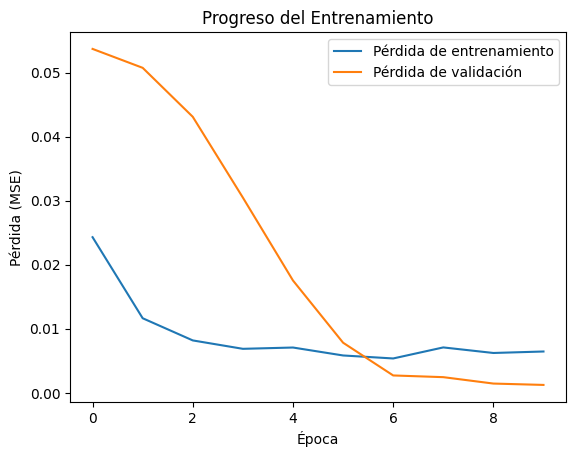

In [ ]:
# Graficar la evolución de la pérdida
import matplotlib.pyplot as plt

# Graficar
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.title('Progreso del Entrenamiento')
plt.legend()
plt.show()

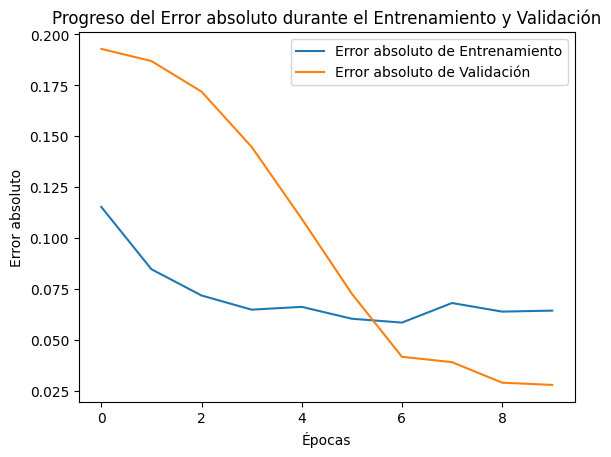

In [ ]:
# Graficar otras métricas si se definen
if 'mae' in history.history:
    plt.plot(history.history['mae'], label='Error absoluto de Entrenamiento')
    plt.plot(history.history['val_mae'], label='Error absoluto de Validación')

plt.xlabel('Épocas')
plt.ylabel('Error absoluto')
plt.title('Progreso del Error absoluto durante el Entrenamiento y Validación')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


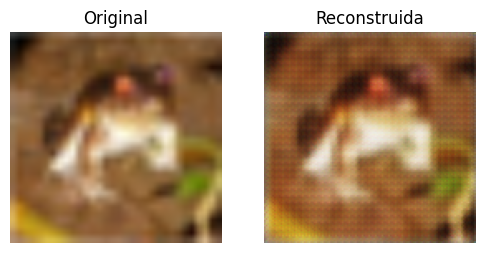

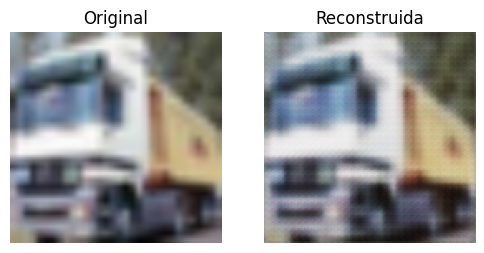

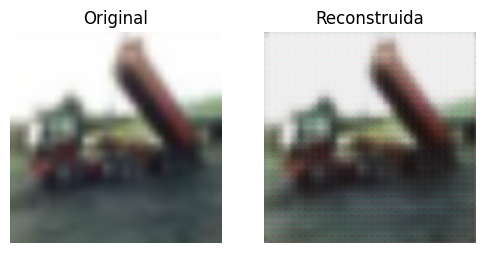

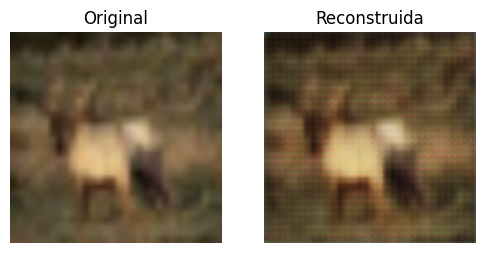

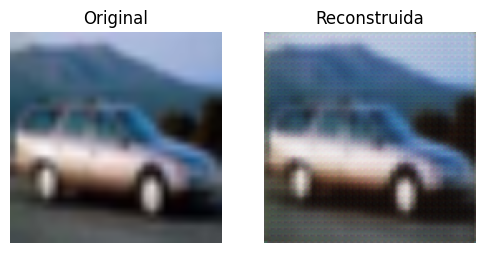

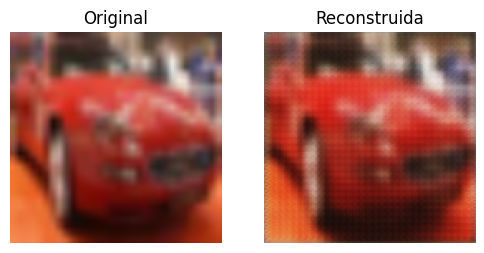

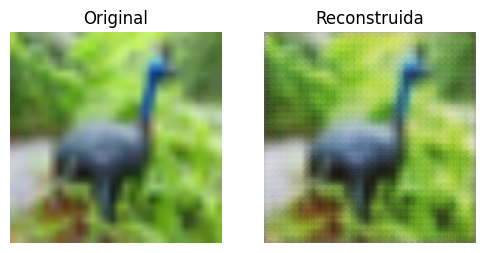

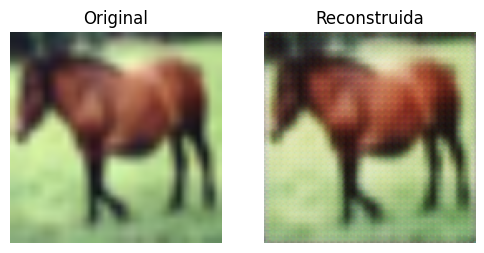

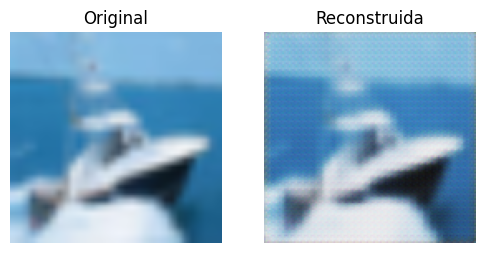

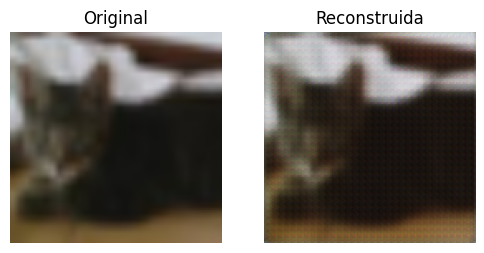

In [ ]:
import matplotlib.pyplot as plt

# Mostrar algunas imágenes de entrada y sus reconstrucciones
num_images_to_display = 10  # Número de imágenes que quieres mostrar

# Tomar un lote de imágenes para probar el modelo
reconstructed_images = model.predict(x_train[:num_images_to_display])  # Usamos las primeras 10 imágenes del conjunto de validación

for i in range(num_images_to_display):
    original = x_train[i]
    reconstructed = reconstructed_images[i]

    # Crear una figura con dos subgráficas (original vs reconstruida)
    plt.figure(figsize=(6, 3))

    # Imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title('Original')
    plt.axis('off')

    # Imagen reconstruida
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed)
    plt.title('Reconstruida')
    plt.axis('off')

    plt.show()